# Data initial exploration - Torch Version
*Matthieu OLEKHNOVITCH*

## Introduction 
This notebook is dedicated to the initial exploration of the data. It is the first step of the data science process. The goal is to get a first idea of the data, to understand it and to identify the main challenges.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import json
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import os

d:\Github\Kaggle-competition---Extractive-Summarization-with-Discourse-Graphs\envducul\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ----------------- Load Training Labels -----------------#

training_label_path = 'training_labels.json'
print(os.path.dirname(os.path.abspath(training_label_path)))
try :
    labels_data = json.load(open(training_label_path))
    print(training_label_path + ' loaded')

except FileNotFoundError:
    print('File not found: ', training_label_path)


# ----------------- Load Training Data -------------------#

training_data_path = 'training/'
discussion_ids = []
for key in labels_data.keys():
    discussion_ids.append(key)

print('Number of discussions: ', len(discussion_ids))



# -------------------------------------------------------#

d:\Github\Kaggle-competition---Extractive-Summarization-with-Discourse-Graphs
training_labels.json loaded
Number of discussions:  97


In [3]:
# ----------------- Load Training Labels -----------------#

training_label_path = 'training_labels.json'
print(os.path.dirname(os.path.abspath(training_label_path)))
try :
    data_training = json.load(open(training_label_path))
except FileNotFoundError:
    print('File not found: ', training_label_path)

print(training_label_path + ' loaded')

# ----------------- Load Training Data -------------------#

training_data_path = 'training/'
discussion_training_ids = []
for key in data_training.keys():
    discussion_training_ids.append(key)

print('Number of discussions: ', len(discussion_training_ids))

# ----------------- Load Test Labels -----------------#

test_label_path = 'test_labels_text_baseline.json'
print(os.path.dirname(os.path.abspath(test_label_path)))
try :
    data_test = json.load(open(test_label_path))
except FileNotFoundError:
    print('File not found: ', test_label_path)

print(test_label_path + ' loaded')

# ----------------- Load Test Data -------------------#

test_data_path = 'test/'
discussion_test_ids = []
for key in data_test.keys():
    discussion_test_ids.append(key)

print('Number of discussions: ', len(discussion_test_ids))



d:\Github\Kaggle-competition---Extractive-Summarization-with-Discourse-Graphs
training_labels.json loaded
Number of discussions:  97
d:\Github\Kaggle-competition---Extractive-Summarization-with-Discourse-Graphs
test_labels_text_baseline.json loaded
Number of discussions:  40


Creating the class for discussion

In [17]:
class Data:
    
    def __init__(self, discussion_ids, type_of_data):
        self.discussion_ids = discussion_ids
        self.type_of_data = type_of_data
    
    def get_discussion_id(self, number):
        print('number: ', number)
        number = int(number)
        discussion_id = self.discussion_ids[number]
        return discussion_id
    
    def get_all(self, number):

        if self.type_of_data == 'training':
            discussion_path = training_data_path + self.get_discussion_id(number) + '.json'
            edges_path = training_data_path + self.get_discussion_id(number) + '.txt'
        elif self.type_of_data == 'test':
            discussion_path = test_data_path + self.get_discussion_id(number) + '.json'
            edges_path = test_data_path + self.get_discussion_id(number) + '.txt'
            
        try :
            discussion_json = json.load(open(discussion_path))
            print('Discussion file loaded')
        except: 
            print('Error loading discussion file')

        num_of_posts = len(discussion_json)
        edges = np.array(np.loadtxt(edges_path, dtype=str))

        return discussion_json, edges, num_of_posts
    
    def get_edges(self, number):
        _, edges, _ = self.get_all(self.get_discussion_id(number))
        return edges
    
    def get_discussion(self, number):
        discussion_json, _, _ = self.get_all(self.get_discussion_id(number))
        return discussion_json
    
    def get_num_of_posts(self, number):
        _, _, num_of_posts = self.get_all(self.get_discussion_id(number))
        return num_of_posts
    
    def get_starting_nodes(self, number):
        edges = self.get_edges(self.get_discussion_id(number))
        starting_nodes = (edges[:, 0]).astype(int)
        return starting_nodes
    
    def get_ending_nodes(self, number):
        edges = self.get_edges(self.get_discussion_id(number))
        ending_nodes = edges[:, 2].astype(int)
        return ending_nodes
    
    def get_edge_index_directed(self, number):
        edge_index_directed = torch.tensor([self.get_starting_nodes(self.get_discussion_id(number)),
                                             self.get_ending_nodes(self.get_discussion_id(number))], dtype=torch.long)
        return edge_index_directed
    
    def get_nodes(self, number):
        nodes = torch.tensor([i for i in range(self.get_num_of_posts(self.get_discussion_id(number)))], dtype=torch.long)
        return nodes
    
    

        
    


# Building a conversation graph (torch version)

In [18]:
Discussions = Data(discussion_training_ids, 'training')
nb = 0

discussion_labels = torch.tensor(data_training[Discussions.get_discussion_id(nb)], dtype=int)
# Convert i to True false
discussion_labels = discussion_labels ==1
print('Numbers of true labels: ', discussion_labels.sum())
print('Number of labels', discussion_labels.shape[0])

print('Starting nodes: ', Discussions.get_starting_nodes(nb))
print('Number of edges: ', len(Discussions.get_edges(nb)))

# Convert egdes[:,1] using label_dict.json
label_dict = json.load(open('label_dict.json'))
edge_labels = []
for i in range(len(Discussions.get_edges(nb))):
    edge_labels.append(label_dict[Discussions.get_edges(nb)[i, 1]])
print(edge_labels)
edge_labels = torch.tensor(edge_labels, dtype=torch.long)

# ----------------- Visualizing graph ---------------------#

data = Data(x=Discussions.get_nodes(nb), edge_index=Discussions.get_edge_index_directed(nb), y = discussion_labels, edge_attr=edge_labels)
print(data)
#convert directed graph to net
g = to_networkx(data, to_undirected=True)
#directed graph
nx.draw(g, node_size=10)

number:  0
Numbers of true labels:  tensor(132)
Number of labels 1095
number:  0
number:  IS1003d


ValueError: invalid literal for int() with base 10: 'IS1003d'

Discussion ID:  IS1003d
Discussion file loaded
Number of posts:  1095
Numbers of true labels:  tensor(132)
Number of labels 1095
Starting nodes:  [   0    1    1 ... 1091 1092 1091]
Number of edges:  1094
[3, 14, 4, 10, 6, 4, 10, 0, 4, 4, 4, 9, 4, 9, 14, 3, 14, 14, 15, 0, 9, 0, 6, 6, 6, 0, 0, 0, 4, 0, 6, 4, 6, 4, 6, 7, 4, 9, 7, 0, 4, 4, 10, 0, 4, 6, 4, 3, 14, 14, 6, 6, 9, 4, 0, 7, 6, 0, 4, 9, 6, 9, 4, 0, 9, 10, 0, 4, 4, 7, 6, 0, 0, 7, 0, 15, 9, 6, 0, 0, 0, 0, 0, 0, 9, 9, 7, 15, 0, 0, 7, 0, 0, 9, 9, 15, 10, 15, 6, 9, 0, 0, 0, 15, 0, 0, 0, 7, 0, 0, 0, 9, 0, 9, 10, 9, 6, 0, 0, 0, 7, 3, 4, 7, 4, 15, 4, 14, 4, 0, 3, 0, 14, 15, 0, 0, 10, 7, 0, 7, 0, 6, 9, 14, 10, 6, 6, 0, 0, 4, 0, 6, 7, 5, 9, 0, 9, 5, 15, 5, 6, 9, 6, 0, 11, 14, 6, 14, 0, 6, 3, 13, 7, 3, 6, 0, 3, 14, 14, 15, 7, 15, 7, 15, 14, 9, 7, 9, 11, 6, 0, 0, 6, 15, 15, 4, 6, 0, 4, 4, 6, 0, 3, 14, 14, 9, 7, 9, 14, 6, 0, 7, 3, 7, 14, 7, 14, 0, 6, 7, 6, 0, 6, 7, 6, 14, 14, 0, 9, 0, 4, 4, 9, 4, 7, 3, 0, 6, 6, 14, 14, 14, 9, 5, 4, 4, 4, 3, 1

d:\Github\Kaggle-competition---Extractive-Summarization-with-Discourse-Graphs\envducul\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)


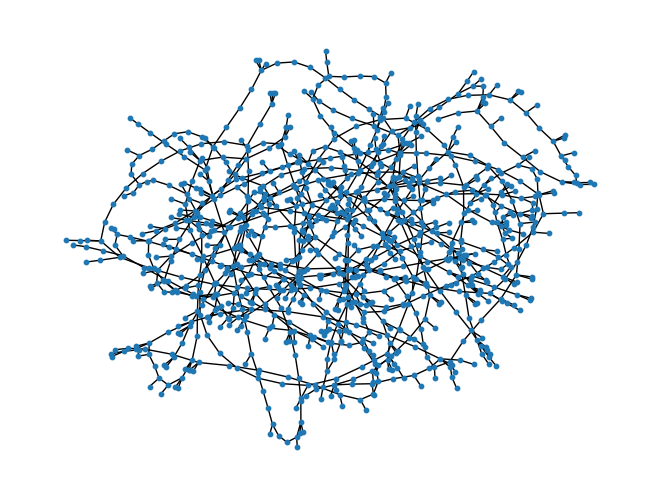

In [3]:
# ------------------ Loading Discussions ----------------#  

discussion_id = discussion_ids[0]                                  # Select a discussion

print('Discussion ID: ', discussion_id)
discussion_path = training_data_path + discussion_id + '.json'
try :
    discussion_json = json.load(open(discussion_path))
    print('Discussion file loaded')
except: 
    print('Error loading discussion file')

num_of_posts = len(discussion_json)
print('Number of posts: ', num_of_posts)

discussion_labels = torch.tensor(labels_data[discussion_id], dtype=int)
# Convert i to True false
discussion_labels = discussion_labels ==1
print('Numbers of true labels: ', discussion_labels.sum())
print('Number of labels', discussion_labels.shape[0])

# ----------------------Loading edges----------------------#

edges_path = training_data_path + discussion_id + '.txt'
edges = np.array(np.loadtxt(edges_path, dtype=str))
starting_nodes = (edges[:, 0]).astype(int)
ending_nodes = edges[:, 2].astype(int)
print('Starting nodes: ', starting_nodes)
print('Number of edges: ', len(edges))

# Convert egdes[:,1] using label_dict.json
label_dict = json.load(open('label_dict.json'))
edge_labels = []
for i in range(len(edges)):
    edge_labels.append(label_dict[edges[i, 1]])
print(edge_labels)
edge_labels = torch.tensor(edge_labels, dtype=torch.long)

# ----------------- Buidling torch graph ------------------#

nodes = torch.tensor([i for i in range(num_of_posts)], dtype=torch.long)
edge_index_directed = torch.tensor([starting_nodes, ending_nodes], dtype=torch.long)

# ----------------- Visualizing graph ---------------------#

data = Data(x=nodes, edge_index=edge_index_directed, y = discussion_labels, edge_attr=edge_labels)
print(data)
#convert directed graph to net
g = to_networkx(data, to_undirected=True)
#directed graph
nx.draw(g, node_size=10)

In [16]:
#print dimension of edge_index_directed
print('Dimension of edge_index_directed: ', edge_index_directed.shape)
#print number of nodes
print('Number of nodes: ', num_of_posts)
#print shape of data.x
print('Shape of data.x: ', data.x.shape)

Dimension of edge_index_directed:  torch.Size([2, 1094])
Number of nodes:  1095
Shape of data.x:  torch.Size([1095])


## Coding the model (Graph Attention Network)

In [4]:
import numpy as np
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
import os
import torch
from torch_geometric.data import Data
import networkx as nx
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import gensim

In [5]:





# class GNNModel(nn.Module):
#     def __init__(self, num_features, hidden_dim, num_classes):
#         super(GNNModel, self).__init__()
#         self.conv1 = GCNConv(num_features, hidden_dim)
#         self.conv2 = GCNConv(hidden_dim, num_classes)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         print(x.shape)
#         print(edge_index.shape)

#         x = F.relu(self.conv1(x, edge_index, node_dim=0))
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index, node_dim=0)

#         return F.log_softmax(x, dim=1)
    
class GNNModel(nn.Module):
    def __init__(self, num_nodes, embedding_dim, hidden_dim, num_classes):
        super(GNNModel, self).__init__()

        # Embedding layer to convert node indices to node representations
        self.embedding = nn.Embedding(num_nodes, embedding_dim)

        self.conv1 = GCNConv(embedding_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Pass node indices through the embedding layer
        x = self.embedding(x)

        # Print shapes for debugging
        # print("Node Features Shape (after embedding):", x.shape)
        # print("Edge Index Shape:", edge_index.shape)

        # Apply the first convolutional layer
        x = F.relu(self.conv1(x, edge_index))

        # Dropout layer
        x = F.dropout(x, training=self.training)

        # Apply the second convolutional layer
        x = self.conv2(x, edge_index)

        # Apply log_softmax for classification
        return F.log_softmax(x, dim=1)
    
your_num_features = data.num_nodes
num_epochs = 10


# Extract labels for a specific identifier (e.g., "IS1003d")
identifier = "IS1003d"
your_ground_truth_labels = torch.tensor(labels_data.get(identifier, []), dtype=torch.long)

    
your_loss_function = nn.CrossEntropyLoss()

#transofm training_label into list
training_label_list = []
for key in labels_data.keys():
    training_label_list.append(labels_data[key])
    

# Exemple d'utilisation
model = GNNModel(num_nodes=your_num_features, embedding_dim=16, hidden_dim=64, num_classes=2)

#model = GNNModel(num_features=your_num_features, hidden_dim=64, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Entraînement
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(data)
    loss = your_loss_function(output, your_ground_truth_labels)
    loss.backward()
    optimizer.step()
    # Print the loss for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

# Évaluation
model.eval()
with torch.no_grad():
    output = model(data)
    predicted_labels = output.argmax(dim=1)
    # Évaluez la performance du modèle selon vos critères

Epoch 1/10, Loss: 0.6235883831977844
Epoch 2/10, Loss: 0.5126485228538513
Epoch 3/10, Loss: 0.445849746465683
Epoch 4/10, Loss: 0.39427679777145386
Epoch 5/10, Loss: 0.38145509362220764
Epoch 6/10, Loss: 0.3795025646686554
Epoch 7/10, Loss: 0.3778480589389801
Epoch 8/10, Loss: 0.37280693650245667
Epoch 9/10, Loss: 0.3806125223636627
Epoch 10/10, Loss: 0.36686578392982483


TypeError: 'torch.Size' object is not callable

In [6]:
from sklearn.metrics import f1_score
# Convert tensors to numpy arrays if needed
predicted_labels_np = predicted_labels.numpy()
your_ground_truth_labels_np = your_ground_truth_labels.numpy()

# Calculate F1 score
f1 = f1_score(your_ground_truth_labels_np, predicted_labels_np, average='binary')  # Adjust 'binary' based on your task

# Print the F1 score
print(f"F1 Score: {f1}")

F1 Score: 0.0


In [25]:
predicted_labels_np.unique()

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [85]:
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GATConv
import torch.nn.functional as F


# Define the GCN model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.gc1 = nn.GraphConvolution(input_dim, hidden_dim)
        self.gc2 = nn.GraphConvolution(hidden_dim, output_dim)

    def forward(self, x, adjacency_matrix):
        x = F.relu(self.gc1(x, adjacency_matrix))
        x = self.gc2(x, adjacency_matrix)
        return F.sigmoid(x)

# Instantiate the model
model = GCN(input_dim=1, hidden_dim=16, output_dim=1)

# Define the loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(x, adjacency_matrix)
    loss = criterion(output[train_idx], y[train_idx])
    loss.backward()
    optimizer.step()

AttributeError: module 'torch.nn' has no attribute 'GraphConvolution'